([<matplotlib.axis.YTick at 0x7e69c4671790>,
 [Text(0, 0, '0'),
  Text(0, 4000000, '400'),
  Text(0, 8000000, '800'),
  Text(0, 12000000, '1200'),
  Text(0, 16000000, '1600'),
  Text(0, 20000000, '2000')])

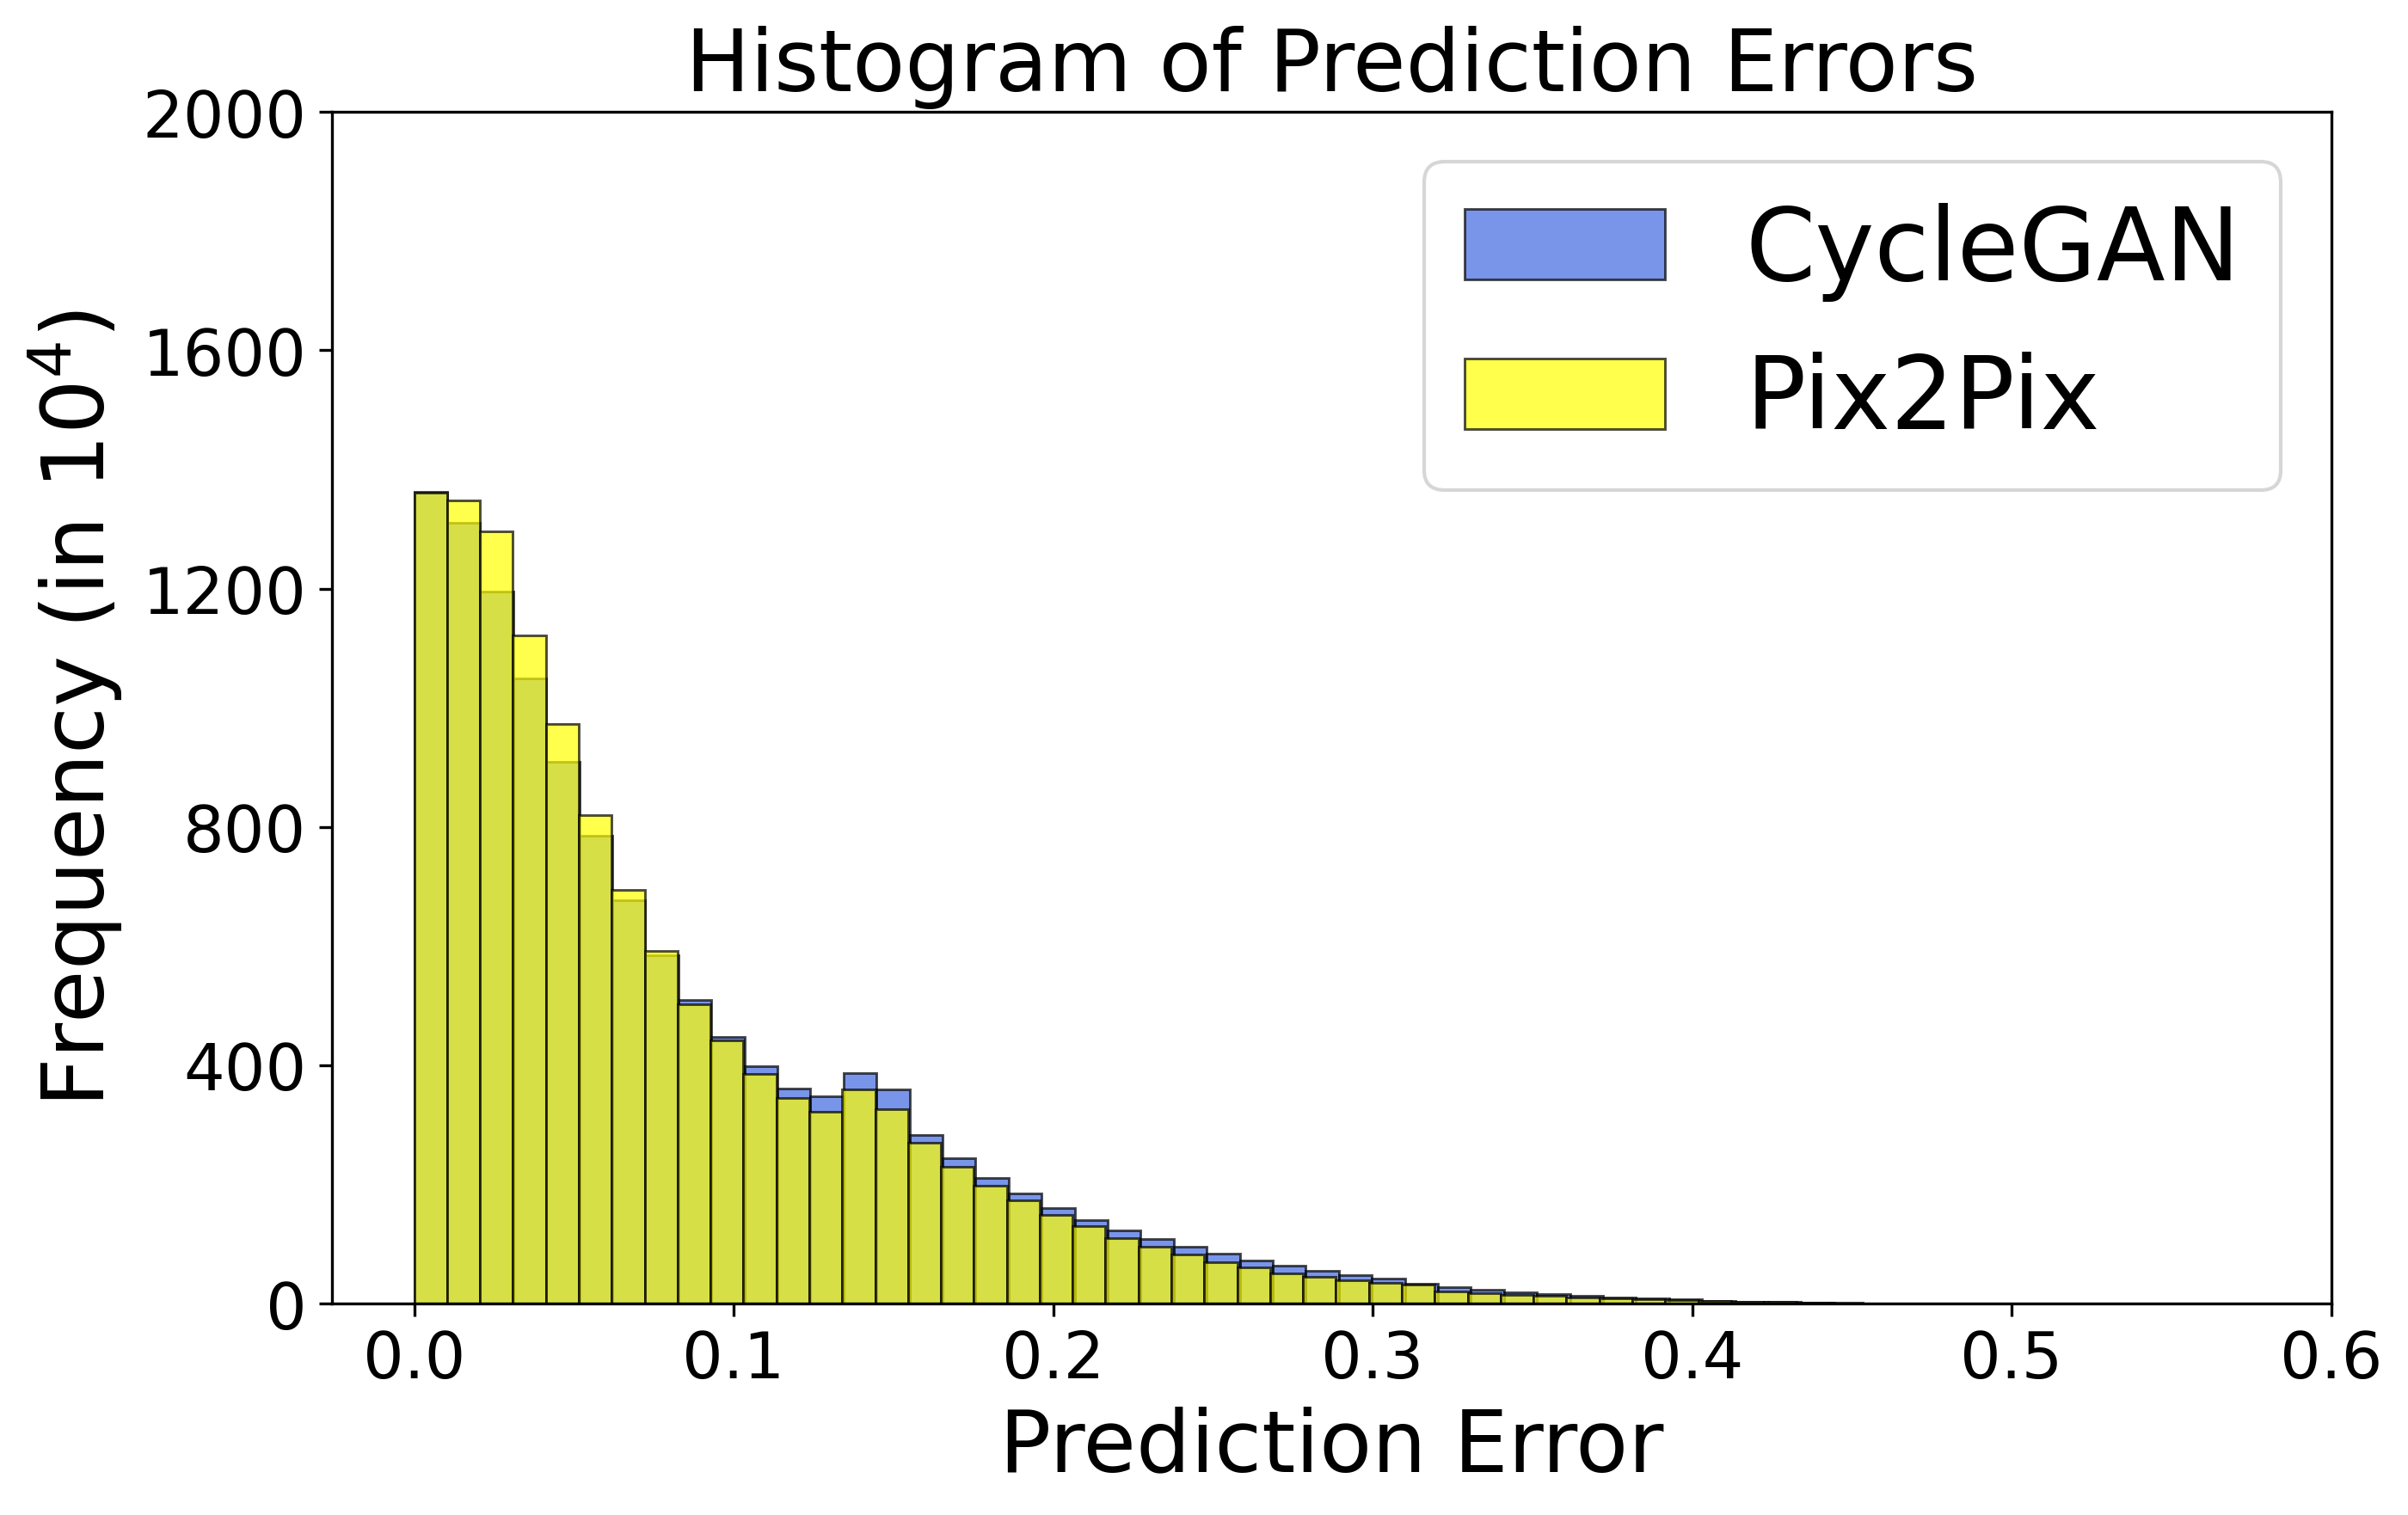

In [3]:
#GAN Objective 2 Pix2Pix2_1.0 #SemanticKitti #Combined for all test set
#Combined Error Histogram of with and without incidence mask from entire folder using Base folder and Subfolder #Voodooed

import os
import torch
from PIL import Image
from generator import Generator
from generator_pix2pix import Generator as Generator_pix2pix
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from transform_utils import lidar_transform, intensity_real_transform, incidence_transform, binary_transform, reflectance_transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(folder, in_channel,input_channel_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if input_channel_config == "T5":  
        model = Generator_pix2pix(in_channels=in_channel, out_channels=1) 
    
        Checkpoint_path = r'/DATA2/Vivek/Code/Implementation/Objective 2/GAN/Model/Output_1.0/{folder}/gen.pth.tar_{folder}_epoch_200'.format(folder=folder)
        
        checkpoint = torch.load(Checkpoint_path, map_location=device)

        model.load_state_dict(checkpoint['state_dict'])
        model.to(device)
        model.eval()

        return model
    
    elif input_channel_config == "T1":  
        

        model = Generator(img_channels=in_channel, out_channels=1) 
        
        Checkpoint_path = r'/DATA2/Vivek/Code/Implementation/Objective 3/CycleGAN/Output_4.0/gen_r.pth.tar_T1'.format(folder=folder)
        
        checkpoint = torch.load(Checkpoint_path, map_location=device)

        model.load_state_dict(checkpoint['state_dict'])
        model.to(device)
        model.eval()

        return model

def compute_masked_error(model, filename, input_channel_config):
    
    paths = {img_type: os.path.join(base_path, subfolder, filename) for img_type, subfolder in zip(subfolders, subfolders)}

    # Load the images using the updated paths
    lidar = lidar_transform(Image.open(paths['test_lidar_depth']).convert("L"))

    intensity = intensity_real_transform(Image.open(paths['test_lidar_intensity']).convert("L"))
    incidence = incidence_transform(Image.open(paths['test_incidence_mask']).convert("L"))
    binary = binary_transform(Image.open(paths['test_binary_mask']).convert("L"))
    reflectance = reflectance_transform(Image.open(paths['test_lidar_reflectance']).convert("L"))

    
    mask_tensor = (binary > 0.5).float()
                                                                                                #Change
    intensity_target = intensity.unsqueeze(0).to(device)

    def inverse_transform(tensor):
        mean = 0.4257
        std = 0.2276
        inv_tensor = tensor * std + mean
        return inv_tensor
    
    #Kitti

    if input_channel_config == "T5":  
        input_data =  torch.cat((binary, incidence,reflectance,lidar), dim=0) #T5#in_channels=4
    elif input_channel_config == "T1":  
        input_data = torch.cat((lidar, incidence, reflectance), dim=0) #T1 #in_channels=3

    else:
        raise ValueError("Invalid input_channel_config")

    input_data = input_data.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_data)

    intensity_target = inverse_transform(intensity_target)
    output = inverse_transform(output)

    error = abs(intensity_target - output)
    error_np = error.squeeze().cpu().detach().numpy()

    mask_np = mask_tensor.squeeze().cpu().detach().numpy()
    mask_bool = mask_np > 0
    masked_error_np = np.where(mask_bool, error_np, np.nan)
    
    return masked_error_np

# Define base paths for input images
base_path = r"/DATA2/Vivek/Data/Trial_3/Test/" #Always keep /
subfolders = ['test_lidar_depth', 'test_lidar_rgb', 'test_color_mask', 'test_incidence_mask', 'test_binary_mask', 'test_lidar_intensity', 'test_lidar_label','test_lidar_reflectance']

folder1 = "T1"
in_channel1 = 3
model1 = load_model(folder1, in_channel1,folder1)

folder2 = "T5"
in_channel2 = 4
model2 = load_model(folder2, in_channel2,folder2)

errors_model1 = []
errors_model2 = []

for filename in os.listdir(os.path.join(base_path, subfolders[0])):
    if filename.endswith('.jpg'):
        masked_error1 = compute_masked_error(model1, filename, folder1)
        masked_error2 = compute_masked_error(model2, filename, folder2)
        
        errors_model1.append(masked_error1)
        errors_model2.append(masked_error2)

# Combine Errors
combined_errors_model1 = np.concatenate(errors_model1)
combined_errors_model2 = np.concatenate(errors_model2)


# Create a combined histogram of the prediction errors
plt.figure(figsize=(10, 6), dpi=300)

# Histogram for With Incidence Angle Mask
plt.hist(combined_errors_model1.flatten(), bins=50, alpha=0.7, color='royalblue', edgecolor='black', linewidth=0.7, label="CycleGAN")

# Histogram for No Incidence Angle Mask 
plt.hist(combined_errors_model2.flatten(), bins=50, alpha=0.7, color='yellow', edgecolor='black', linewidth=0.7, label="Pix2Pix")

plt.xlabel('Prediction Error', fontsize=24)
x_ticks = np.arange(0, 0.7, 0.1)  # This sets ticks from 0 to 2 in increments of 0.1
plt.xticks(x_ticks, fontsize=18)

order = r'in $10^4$'
# Add a label for the entire y-axis scale with adjusted spacing
plt.ylabel(f"Frequency ({order})", fontsize=24, labelpad=5)

# Add a separate label for 'x 10^4' at the upper left
#plt.text(0.02, 0.95, r'$\times 10^4$', va='center', ha='left', fontsize=18, transform=plt.gca().transAxes)

plt.title('Histogram of Prediction Errors', fontsize=24)
plt.legend(loc='upper right', fontsize=28)

# Set y-ticks with a step size of 10,000 (10^4)
y_ticks = np.arange(0, 20000001, 4000000)
plt.yticks(y_ticks, labels=[f"{int(val/10000)}" for val in y_ticks], fontsize=18)

#plt.savefig(f'/DATA2/Vivek/Combined Histogram on Test Set/IA+MR/SemanticKitti/GAN/{folder1}_{folder2}/Comb_Hist_Test_{folder1}_{folder2}.png')


([<matplotlib.axis.YTick at 0x7e69580bab20>,
 [Text(0, 0, '0'),
  Text(0, 4000000, '400'),
  Text(0, 8000000, '800'),
  Text(0, 12000000, '1200'),
  Text(0, 16000000, '1600')])

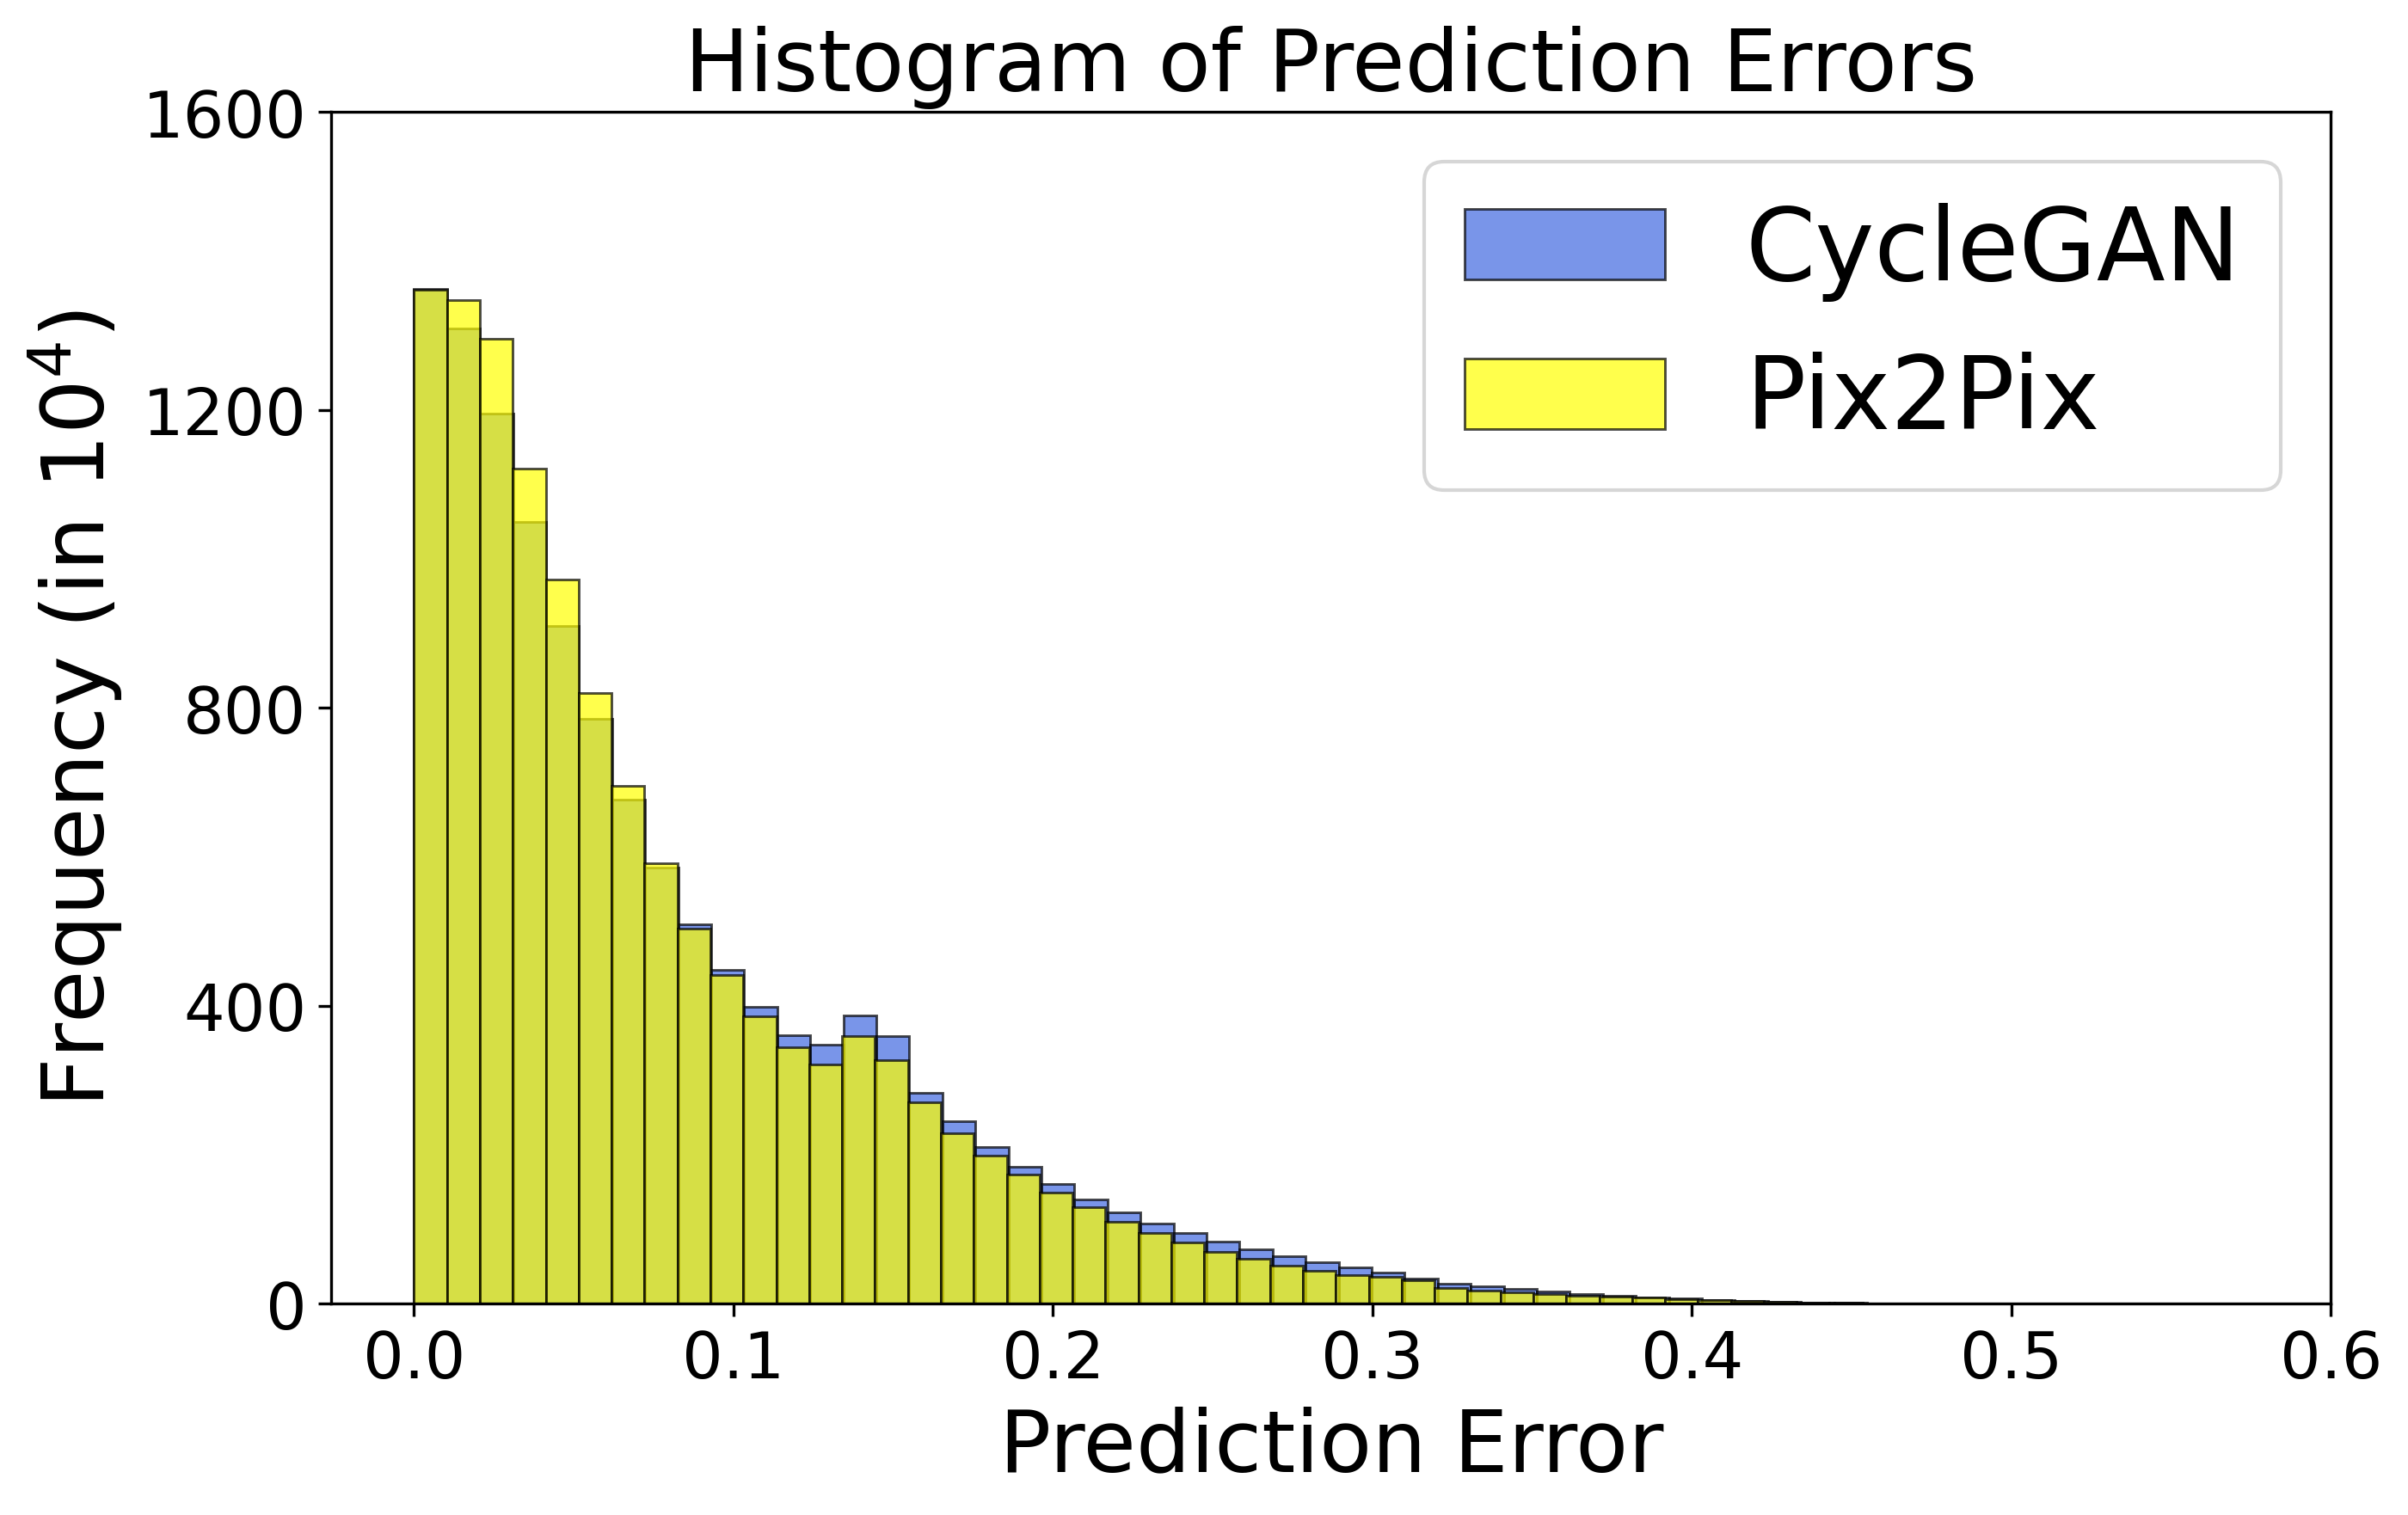

In [6]:
# Create a combined histogram of the prediction errors
plt.figure(figsize=(10, 6), dpi=300)

# Histogram for With Incidence Angle Mask
plt.hist(combined_errors_model1.flatten(), bins=50, alpha=0.7, color='royalblue', edgecolor='black', linewidth=0.7, label="CycleGAN")

# Histogram for No Incidence Angle Mask 
plt.hist(combined_errors_model2.flatten(), bins=50, alpha=0.7, color='yellow', edgecolor='black', linewidth=0.7, label="Pix2Pix")

plt.xlabel('Prediction Error', fontsize=24)
x_ticks = np.arange(0, 0.7, 0.1)  # This sets ticks from 0 to 2 in increments of 0.1
plt.xticks(x_ticks, fontsize=18)

order = r'in $10^4$'
# Add a label for the entire y-axis scale with adjusted spacing
plt.ylabel(f"Frequency ({order})", fontsize=24, labelpad=5)

# Add a separate label for 'x 10^4' at the upper left
#plt.text(0.02, 0.95, r'$\times 10^4$', va='center', ha='left', fontsize=18, transform=plt.gca().transAxes)

plt.title('Histogram of Prediction Errors', fontsize=24)
plt.legend(loc='upper right', fontsize=28)

# Set y-ticks with a step size of 10,000 (10^4)
y_ticks = np.arange(0, 16000001, 4000000)
plt.yticks(y_ticks, labels=[f"{int(val/10000)}" for val in y_ticks], fontsize=18)

#plt.savefig(f'/DATA2/Vivek/Combined Histogram on Test Set/Material Reflectance/SemanticKitti/GAN/{folder1}_{folder2}/Comb_Hist_Test_{folder1}_{folder2}.png')
